<h1>Trump's Tweets</h1>
<div class="alert alert-block alert-warning">
<p>This is a quick analysis I did of Donald Trump's tweets. I don't use Twitter but every few months I'll do a thought experiment where I read his latest handful of tweets and imagine how this country would've reacted had Barack Obama said anything remotely similar (remember when people got mad at Barack for wearing a tan suit!?). Recently, Twitter flagged ~5 consecutive Trump tweets and that motivated me to do this.
</p>
</div>

In [318]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import contractions
import inflect
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk import stem
from nltk.corpus import stopwords
from nltk.stem import wordnet
from nltk import tokenize
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model
from sklearn import model_selection
import textblob
import wordcloud

import datetime
from dateutil import parser as date_parser
import os
import pytz
import random
import re
import string
import unicodedata

<h2>Data import</h2>
<div class="alert alert-block alert-warning">
<p>I'm just importing the data here and inspecting the first few rows to see what the dataset looks like. Shoutout to <a href="https://www.thetrumparchive.com/" target="_blank">The Trump Archive</a> for providing an exportable feed of all his tweets.
</p>
</div>

In [4]:
TZ_UTC = pytz.utc
TZ_EST = pytz.timezone('US/Eastern')


def read_egomaniac_tweets():
    df = pd.read_csv("./tweets_11-06-2020.csv")
    df['is_retweet'] = df.isRetweet.apply(lambda x: x == "t")
    df['is_deleted'] = df.isDeleted.apply(lambda x: x == "t")
    df = df[df.is_retweet == False]
    df['date'] = df.date.apply(lambda x: date_parser.parse(x).replace(tzinfo=TZ_UTC).astimezone(TZ_EST))
    df['time'] = df.date.apply(lambda x: x.time())
    df['text_length'] = df.text.apply(len)
    df = df[df.text_length >= 10]
    return df.drop(columns=['isRetweet', 'isDeleted'])
    

In [5]:
df = read_egomaniac_tweets()

In [149]:
df.head(3)

,id,text,device,favorites,retweets,date,is_retweet,is_deleted,time,text_length
0,98454970654916608,Republicans and Democrats have both created ou...,TweetDeck,49,255,2011-08-02 14:07:48-04:00,False,False,14:07:48,66
1,1234653427789070336,I was thrilled to be back in the Great city of...,Twitter for iPhone,73748,17404,2020-03-02 20:34:50-05:00,False,False,20:34:50,279
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,Twitter for iPhone,80527,23502,2020-09-12 16:10:58-04:00,False,False,16:10:58,290


<h2>The favorite tweet</h2>
<div class="alert alert-block alert-warning">
<p>I wanted to see what his most favorited tweet was... I wasn't expecting this...
</p>
</div>

In [150]:
pd.options.display.max_colwidth = -1
df.sort_values(by='favorites', ascending=False)[['text', 'favorites', 'date']].head(1)

,text,favorites,date
10252,"Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!",1869706,2020-10-02 00:54:06-04:00


In [151]:
pd.options.display.max_colwidth = 50  # set us back to the default column width
df.text_length.mean().astype('int64')

128

<h2>Favorites and retweets over time</h2>
<div class="alert alert-block alert-warning">
<p>Huh, remember when no one paid attention to what he had to say? What a glorious time it will be if he starts trending back to pre-2015 popularity.
</p>
</div>

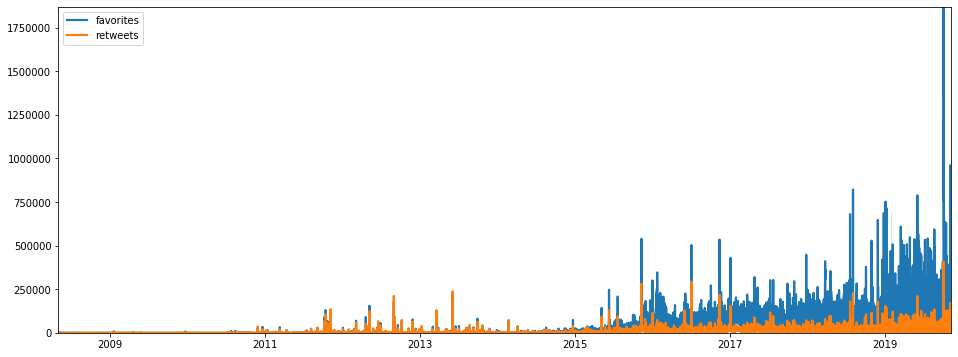

In [767]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_ylim(0, max(df.favorites.max(), df.retweets.max()))
df_date = df.set_index('date')
ax.set_xlim(df.date.min(), df.date.max())
for column in ('favorites', 'retweets'):
    sns.lineplot(data=df_date[column], label=column, linewidth=2.2, ax=ax)
_ = ax.legend()

<div class="alert alert-block alert-warning">
<p>He tweets a lot.</p>
</div>

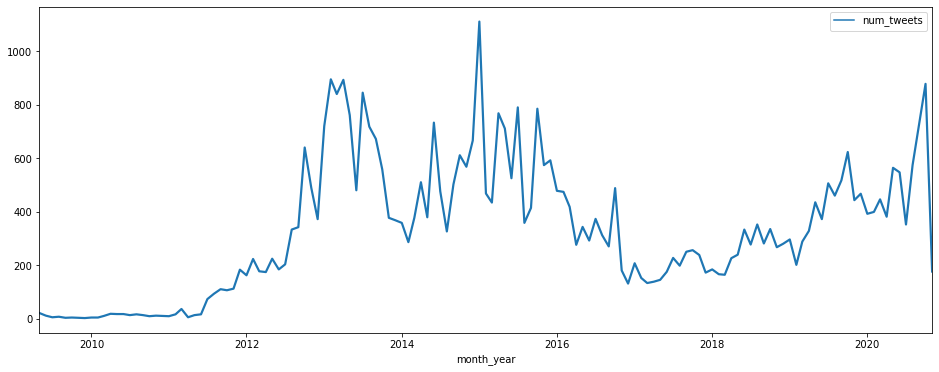

In [8]:
df['month_year'] = df.date.apply(lambda x: datetime.date(x.year, x.month, 1))
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(df.month_year.min(), df.month_year.max())
sns.lineplot(data=df.groupby('month_year').count()[['id']].rename(columns={'id': 'num_tweets'}),
             linewidth=2.2,
             ax=ax)
_ = ax.legend()

<h2>Reading his words</h2>
<div class="alert alert-block alert-warning">
<p>After looking at some metrics around his tweets, I wanted to explore their content a bit. First, I needed to clean up the tweets to remove things like URLs/links, user mentions, etc. I also apply some other common techniques that are used in the analysis of text. I remove punctuation, stop words, and tokenize the text to normalize each tweet before analyzing them. I create a new column (cleaner_tweet) to store this processed tweet content.
</p>
</div>

In [135]:
# tokenizer and functions for cleaning up the tweets (some of these are borrowed)
TWEET_TOKENIZER = tokenize.TweetTokenizer(strip_handles=True)
NUM_2_WORD_ENG = inflect.engine()


def fix_contractions(text):
    return contractions.fix(text)


def remove_url(text):
    return re.sub(r"http\S+", "", text)


def remove_broken_ampersand(text):
    # we have ill formatted ampersands, remove em
    return re.sub(r"\&amp", "", text)


def remove_non_ascii(words):
    return [
        unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') 
        for word in words
    ]


def to_lowercase(words):
    return [word.lower() for word in words]


def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


def numbers_to_words(words):
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = NUM_2_WORD_ENG.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words


def remove_stopwords(words):
    english_stopwords = stopwords.words('english')
    return [word for word in words if word not in english_stopwords]


def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words


def preprocess_tweet(tweet):
    x = remove_url(tweet)
    x = fix_contractions(x)
    x = remove_broken_ampersand(x)
    words = TWEET_TOKENIZER.tokenize(x)
    return normalize(words)


In [ ]:
df['cleaner_tweet'] = df.text.apply(preprocess_tweet)

<h3>Word clouds</h3>
<div class="alert alert-block alert-warning">
<p>A common way to visualize the most frequently used words in a text document is via the use of a word cloud. Below I write a function that accepts a dataframe of tweets and creates a word cloud of the most common words.
</p>
</div>

In [139]:
def word_cloud(df):
    all_words = ' '.join([word for words in df.cleaner_tweet for word in words])
    cloud = wordcloud.WordCloud(width=900, height=450, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(12, 8))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

<div class="alert alert-block alert-warning">
<p>Here I split the data up into 3 separate dataframes; 1 for pre 2016 election tweets, 1 for tweets during the 2016 election, and 1 for all post 2016 election tweets. Then I use the word cloud function defined above to visualize the most frequent words.
</p>
</div>

In [140]:
announcement = datetime.date(2015, 6, 16)
elected = datetime.date(2016, 11, 15)

pre_election = df[df.month_year < announcement]
election = df[(df.month_year >= announcement) & (df.month_year < elected)]
post_election = df[df.month_year >= elected]

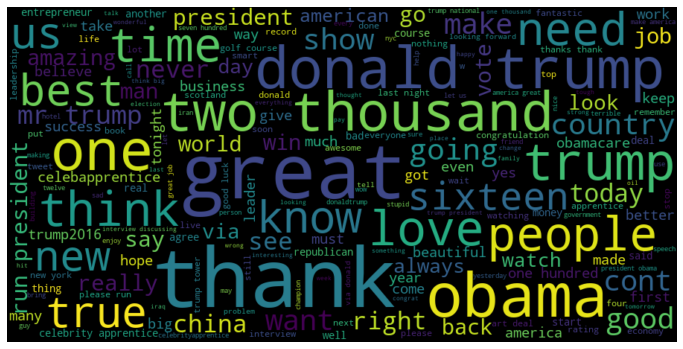

In [141]:
word_cloud(pre_election)

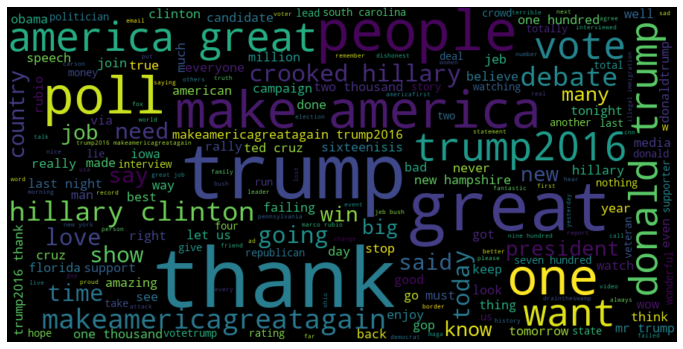

In [142]:
word_cloud(election)

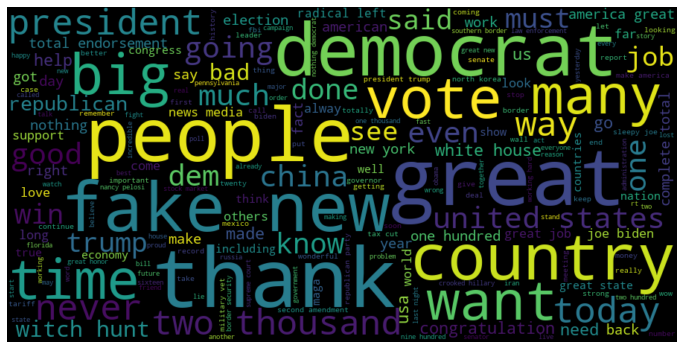

In [143]:
word_cloud(post_election)

<h2>Sentiment analysis</h2>
<div class="alert alert-block alert-warning">
<p>Next I wanted to train a simple model to use for sentiment analysis. I found a training dataset available online that had ~30k tweets categorized as toxic vs not toxic. Below I read in the training dataset and convert it to a matrix of tf-idf features. tf-idf is a statistical measurement that will try to determine a word's importance to a document in a collection (<a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" target="_blank">read about tf-idf on wikipedia here</a>). Then I use this matrix to train a simple regression model and define a function that can use the trained model to try to find the most negative Trump tweets. 
</p>
</div>

In [144]:
def read_training_data():
    df = pd.read_csv("./datasets/train.csv")
    return df

In [152]:
df_training = read_training_data()
df_training['cleaner_tweet'] = df_training.tweet.apply(preprocess_tweet).apply(lambda x: ' '.join(x))

In [714]:
TFIDF_V = TfidfVectorizer(max_df=0.9, min_df=2, max_features=100, stop_words='english')


def predict(model, df, threshold=0.4):
    test_tfidf = TFIDF_V.fit_transform(df.cleaner_tweet.apply(lambda x: ' '.join(x)))

    prediction = model.predict_proba(test_tfidf)
    prediction = prediction[:,1] >= threshold
    df['label'] = prediction.astype(np.int)
    
    df_predict = df[df.label == 1]
    word_cloud(df_predict)


train_tfidf = TFIDF_V.fit_transform(df_training.cleaner_tweet)
xtrain_bow, xvalid_bow, ytrain, yvalid = model_selection.train_test_split(
    train_tfidf, df_training['label'], random_state=42, test_size=0.3)

lreg = linear_model.LogisticRegression()
_ = lreg.fit(xtrain_bow, ytrain) # training the model

<div class="alert alert-block alert-warning">
<p>Below are the word clouds generated from Trump's most negative tweets (as determined by this simple model), first using the entire dataset and second using his more recent tweets from March 2020 to present day (November 2020).
</p>
</div>

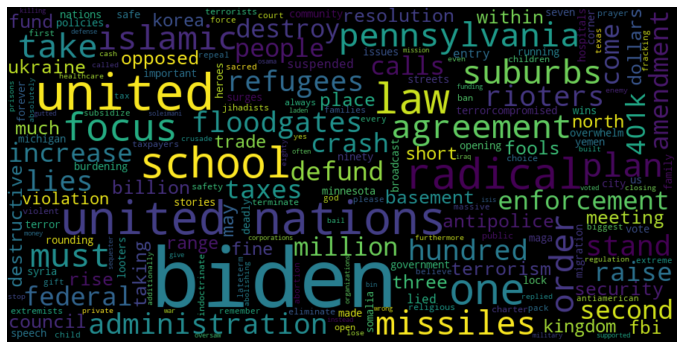

In [724]:
predict(lreg, df, 0.5)

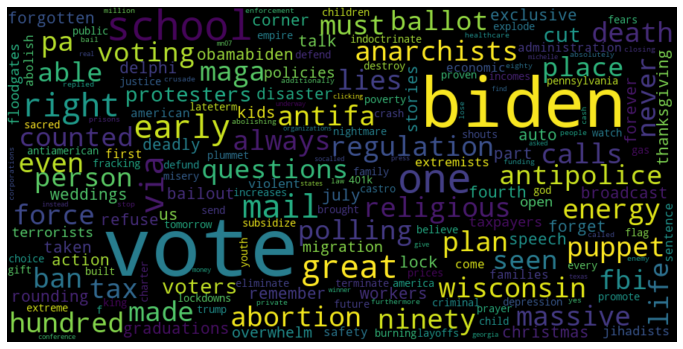

In [766]:
predict(lreg, df[df.month_year >= datetime.date(2020, 3, 1)], 0.45)